In [1]:
from rul_pm.dataset.CMAPSS import CMAPSSDataset, sensor_indices
from rul_pm.transformation.transformers import Transformer, transformation_pipeline
from rul_pm.models.keras import  KerasTrainableModel, XiangQiangJianQiaoModel
from rul_pm.models.keras.losses import weighted_categorical_crossentropy
from rul_pm.models.keras.attention import Attention
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from rul_pm.iterators.batcher import get_batcher, dataset_map, get_features
from tensorflow.keras import backend as K, Model, Input, optimizers

In [2]:
from tensorflow.keras.layers import TimeDistributed 
from tensorflow.keras.layers import (Layer, Conv1D, Dense, Add, Input, AveragePooling1D,
                                     BatchNormalization, LayerNormalization, Flatten,
                                     Concatenate, Bidirectional, Conv2D, MaxPooling1D,
                                     Permute, TimeDistributed, Multiply, LeakyReLU,    
                                     GlobalAveragePooling1D, MaxPooling2D,
                                     Softmax, AveragePooling2D,
                                     ConvLSTM2D ,SpatialDropout2D, LocallyConnected1D,
                                     multiply, concatenate, Activation, Masking,
                                     Masking, LSTM, GRU, MaxPool1D, Conv1D, Dropout, Average,
                                     Reshape, UpSampling1D, AveragePooling1D,GaussianNoise,
                                     Concatenate, Bidirectional)
from tcn import TCN
from tensorflow.keras import backend as K, Model, Input, optimizers
import tensorflow as tf

In [3]:
train_dataset = CMAPSSDataset(train=True, model='FD001')
test_dataset = CMAPSSDataset(train=False, model='FD001')

FD001


In [4]:
sensors = ['SensorMeasure1',
       'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5',
       'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9',
       'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12',
       'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15',
       'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18',
       'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']

useful_sensors = [sensors[i-1] for i in sensor_indices]

# 1. Remaining useful life estimation in prognostics using deep convolution neural networks
Author 
* Xiang Li
* Qian Ding
* Jian-Qiao Sunc

https://www.sciencedirect.com/science/article/pii/S0951832017307779?casa_token=DHKuBa83HrcAAAAA:-U6kHeTYyqmo9XYB8Wm-hOFOx-2IMOC_o5bhZEpdEW8tTB8zliBx9kzxiFuqX6pu_lf7nAQDqeq-#tbl0002


A deep learning method for prognostics is proposed based on convolution neural networks. Dropout technique is employed to relieve overfitting problem. Experiments are carried out on the popular C-MAPSS dataset to show the effectiveness of the proposed method. The goal of the task is to estimate the remaining useful life of aero-engine units accurately. With raw feature selection, data pre-processing and sample preparation using time window, good prognostic performance is achieved with the proposed method, and small error between the prediction and the actual RUL value is obtained for the testing data. The RUL in the life-time of the engine units can be well predicted, especially for the late period close to failure.


In [5]:
from rul_pm.transformation.target import PicewiseRULThreshold
transformer = Transformer(
                'RUL',
                transformation_pipeline(                                
                    scaler=MinMaxScaler((-1, 1)),
                    features=useful_sensors
                ),
                transformerY = Pipeline(steps=[
                    ('picewise', PicewiseRULThreshold(125))
                ])
            )



In [68]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=0)) 
    
def scheduler(epoch, lr): 
    if epoch < 200:
        return 0.001
    else:
        return 0.0001
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
model = XiangQiangJianQiaoModel(
            10,
            10,           
            dropout=0.5,
            window=30,
            batch_size=512,
            step = 1,
            transformer=transformer,
            shuffle='all',
            models_path=Path('.'),
            patience=15,
            cache_size=120,
            callbacks=[lr_callback],
            learning_rate=1e-3,
            loss=root_mean_squared_error)

In [69]:
model.fit(train_dataset, test_dataset, epochs=100)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 14)]          0         
_________________________________________________________________
lambda (Lambda)              (None, 30, 14, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 14, 10)        110       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 14, 10)        1010      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 14, 10)        1010      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 14, 10)        1010      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 14, 1)         31   

35/35 [==============================] - 7s 189ms/step - loss: 15.1599 - root_mean_squared_error: 12.4155 - val_loss: 20.6407 - val_root_mean_squared_error: 17.6825 - lr: 0.0010
Epoch 35/100
35/35 [==============================] - 7s 188ms/step - loss: 15.8545 - root_mean_squared_error: 12.8617 - val_loss: 15.6858 - val_root_mean_squared_error: 13.8511 - lr: 0.0010
Epoch 36/100
35/35 [==============================] - 7s 202ms/step - loss: 14.6749 - root_mean_squared_error: 11.8749 - val_loss: 15.1913 - val_root_mean_squared_error: 13.1649 - lr: 0.0010
Epoch 37/100
35/35 [==============================] - 7s 191ms/step - loss: 14.2846 - root_mean_squared_error: 11.4962 - val_loss: 15.5829 - val_root_mean_squared_error: 13.2702 - lr: 0.0010
Epoch 38/100
35/35 [==============================] - 6s 184ms/step - loss: 14.7703 - root_mean_squared_error: 11.7929 - val_loss: 15.3155 - val_root_mean_squared_error: 13.0184 - lr: 0.0010
Epoch 39/100
35/35 [==============================] - 6s 1

35/35 [==============================] - 6s 182ms/step - loss: 11.9493 - root_mean_squared_error: 8.6526 - val_loss: 12.8367 - val_root_mean_squared_error: 9.2277 - lr: 0.0010
Epoch 78/100
35/35 [==============================] - 6s 182ms/step - loss: 11.7696 - root_mean_squared_error: 8.5070 - val_loss: 12.5296 - val_root_mean_squared_error: 8.7314 - lr: 0.0010
Epoch 79/100
35/35 [==============================] - 6s 183ms/step - loss: 11.9134 - root_mean_squared_error: 8.6652 - val_loss: 12.7317 - val_root_mean_squared_error: 9.1748 - lr: 0.0010
Epoch 80/100
35/35 [==============================] - 6s 182ms/step - loss: 11.8902 - root_mean_squared_error: 8.5778 - val_loss: 12.8006 - val_root_mean_squared_error: 9.0440 - lr: 0.0010
Epoch 81/100
35/35 [==============================] - 6s 183ms/step - loss: 11.7665 - root_mean_squared_error: 8.5020 - val_loss: 12.7653 - val_root_mean_squared_error: 9.2205 - lr: 0.0010
Epoch 82/100
35/35 [==============================] - 6s 182ms/step 

{'parameters': {'window': 30,
  'batch_size': 512,
  'step': 1,
  'shuffle': 'all',
  'patience': 15,
  'transformer': {'target_column': 'RUL',
   'features': None,
   'transformerX': [('initial_selection',
     {'features': ['SensorMeasure2',
       'SensorMeasure3',
       'SensorMeasure4',
       'SensorMeasure7',
       'SensorMeasure8',
       'SensorMeasure9',
       'SensorMeasure11',
       'SensorMeasure12',
       'SensorMeasure13',
       'SensorMeasure14',
       'SensorMeasure15',
       'SensorMeasure17',
       'SensorMeasure20',
       'SensorMeasure21'],
      'features_indices': [5,
       6,
       7,
       10,
       11,
       12,
       14,
       15,
       16,
       17,
       18,
       20,
       23,
       24]}),
    ('resampler', None),
    ('locater', None),
    ('numeric_pipe',
     [('pandas_transformation', None),
      ('to_numpy', {}),
      ('outlier_removal', None),
      ('NullProportionSelector',
       {'min_null_proportion': 0.5,
        'not_n

In [73]:
model.history.history

{'loss': [81.74022674560547,
  76.51426696777344,
  73.35403442382812,
  70.3314437866211,
  67.4042739868164,
  64.53936004638672,
  61.74407196044922,
  58.987342834472656,
  56.25856399536133,
  53.59922790527344,
  50.99798583984375,
  48.457496643066406,
  45.95882797241211,
  43.52682113647461,
  41.17436599731445,
  38.89944076538086,
  36.61524963378906,
  34.596031188964844,
  32.64147186279297,
  30.787363052368164,
  28.839561462402344,
  26.960189819335938,
  25.266998291015625,
  23.705078125,
  22.562524795532227,
  21.17374038696289,
  20.031082153320312,
  19.20885467529297,
  18.197072982788086,
  17.57615852355957,
  16.766660690307617,
  16.171939849853516,
  15.516234397888184,
  15.159907341003418,
  15.854486465454102,
  14.67489242553711,
  14.28459644317627,
  14.770296096801758,
  14.171730041503906,
  13.942781448364258,
  13.474492073059082,
  13.440122604370117,
  13.832595825195312,
  13.302244186401367,
  13.079717636108398,
  13.53715705871582,
  13.01250

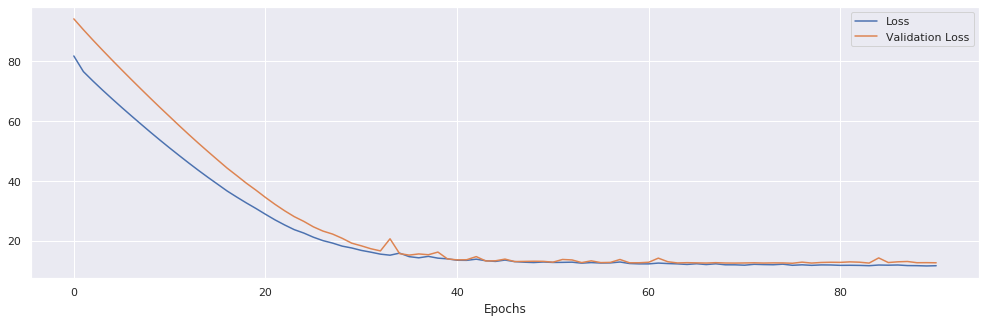

In [79]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(model.history.history['loss'], label='Loss')
ax.plot(model.history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epochs')
ax.legend()

# 1.1 Training set results

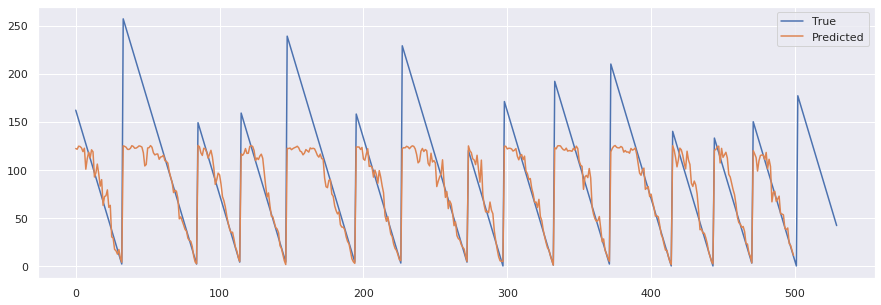

In [80]:
v = model.predict(train_dataset, step=5)
pred_cont = v
true_data = get_features(train_dataset, step=5, window=30, features=['RUL'])
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(true_data['RUL'][0:530], label='True')
ax.plot(pred_cont[0:500], label='Predicted')
ax.legend()

(<Figure size 1800x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff0c9455910>)

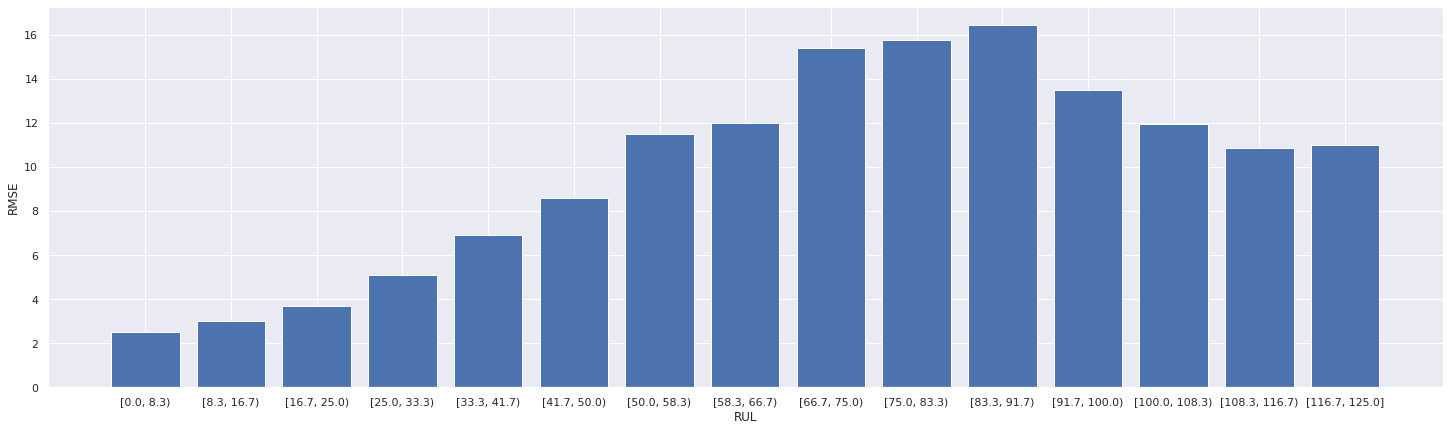

In [81]:
val_rul = np.array(true_data['RUL'])
pred_cont = np.squeeze(pred_cont)
plot_errors_wrt_RUL(val_rul, pred_cont, 125, 15, figsize=(25, 7))

## 1.1 Test set results

In [82]:

v = model.predict(test_dataset, step=1)
#predicted_probas = v
#idx_tensor = transformer.transformerY['scale'].value_ranges[:-1]
#pred_cont = np.sum(predicted_probas * idx_tensor, axis=1)
pred_cont = v
true_data = get_features(test_dataset, step=1, window=30, features=['RUL'])

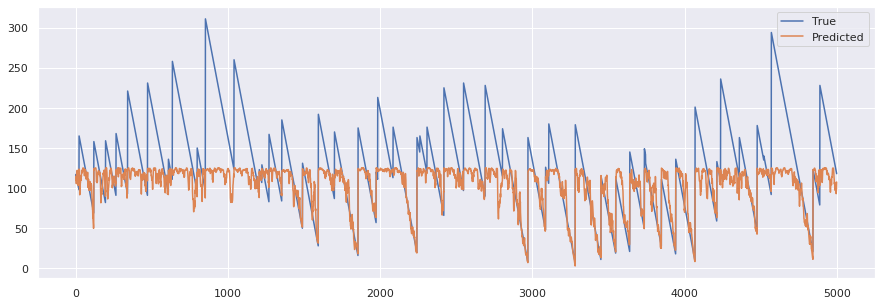

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(true_data['RUL'][0:5000], label='True')
ax.plot(pred_cont[0:5000], label='Predicted')
ax.legend()

(<Figure size 1800x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff0c93389d0>)

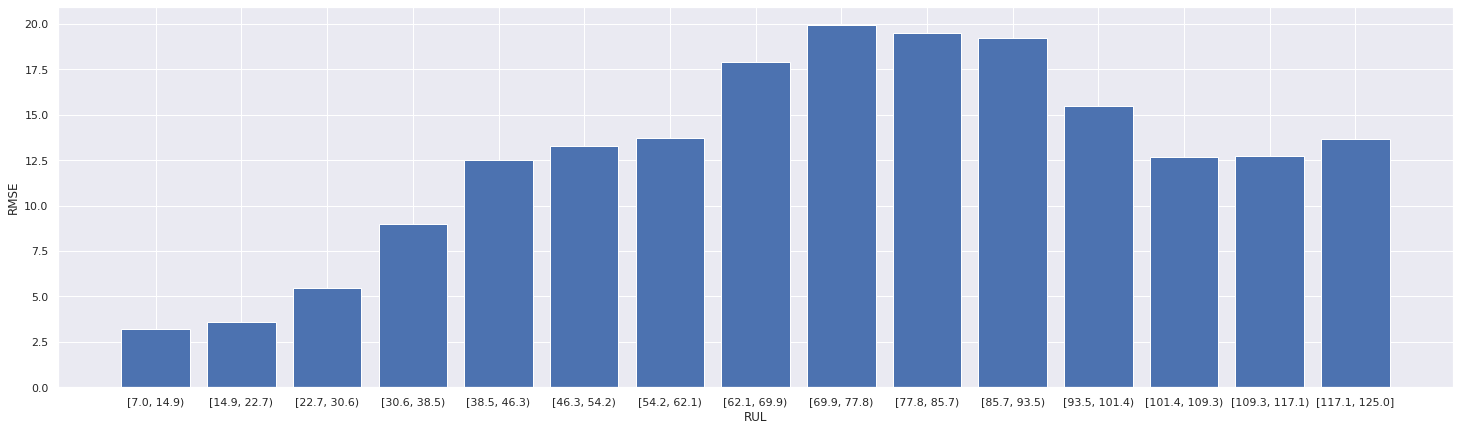

In [84]:
import seaborn as sbn
val_rul = np.array(true_data['RUL'])
pred_cont = np.squeeze(pred_cont)
plot_errors_wrt_RUL(val_rul, pred_cont, 125, 15, figsize=(25, 7))